# Imports

In [ ]:
# Import needed libraries
import numpy as np
import tensorflow as tf
import pandas as pd

import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers, optimizers, callbacks
from tensorflow.keras.losses import categorical_crossentropy

import cv2
import requests
import datetime
import os
from google.colab import drive
drive.mount('/content/drive')	# Connect with Google Drive

import matplotlib.pyplot as plt
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix
import pylab as pl


# Print TensorFlow and Keras versions
print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)


# Force to use the GPU, otherise training would take too much time
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("\n---------------------------------------------------------------\n")


Mounted at /content/drive
Tensorflow version 2.4.0
Keras version 2.4.3
Found GPU at: /device:GPU:0

---------------------------------------------------------------



# Load data

In [ ]:
# Load data (4774 images from 20 classes)
# Get data from https://drive.google.com/drive/folders/0Bxxqx_AAp2u2Zkp4cGxoNVEzb3M
# Place data in a Google Drive folder and set the datadir variable below with the path of this folder

datadir = '/content/drive/My Drive/Colab Notebooks/ARGOS_public'
trainingset = datadir + '/train/'
testset = datadir + '/test/'

data_augmentation_level = 2   # Level of data augmentation [0: none, 1: low, 2: high]
batch_size = 32               # 32 or 64 depending on situation
input_shape = ()

# Create training set below (with data augmentation)

if data_augmentation_level == 0:
    train_datagen = ImageDataGenerator(rescale = 1. / 255)
    train_shuffle = False
elif data_augmentation_level == 1:
    train_datagen = ImageDataGenerator(
        rescale = 1. / 255,
        zoom_range = 0.1,
        rotation_range = 10
    )
    train_shuffle = False
else:    
    train_datagen = ImageDataGenerator(
    	rescale = 1. / 255,
        zoom_range = 0.1,
        rotation_range = 20,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
    )
    train_shuffle = True

train_generator = train_datagen.flow_from_directory(
    directory = trainingset,
    target_size = (224,224),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = train_shuffle
)

# Create validation set below

test_datagen = ImageDataGenerator(rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory = testset,
    target_size = (224,224),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = False
)

# Resulting numbers
num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape
classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)
print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))
print('Data augmentation level: %d' %(data_augmentation_level))
print("\n---------------------------------------------------------------\n")



# Show n random images
'''
n = 3
x,y = train_generator.next()	# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  		# Categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()
print("\n---------------------------------------------------------------\n")
'''


Found 4774 images belonging to 20 classes.
Found 1686 images belonging to 20 classes.
Image input (224, 224, 3)
Classes: ['Acqua', 'Alilaguna', 'Ambulanza', 'Barchino', 'Cacciapesca', 'Caorlina', 'Gondola', 'Lancia', 'Motobarca', 'Motopontonerettangolare', 'MotoscafoACTV', 'Mototopo', 'Patanella', 'Polizia', 'Raccoltarifiuti', 'Sandoloaremi', 'Sanpierota', 'Topa', 'VaporettoACTV', 'VigilidelFuoco']
Loaded 4774 training samples from 20 classes.
Loaded 1686 test samples from 20 classes.
Data augmentation level: 2

---------------------------------------------------------------



'\nn = 3\nx,y = train_generator.next()\t# x,y size is train_generator.batch_size\n\nfor i in range(0,n):\n    image = x[i]\n    label = y[i].argmax()  \t\t# Categorical from one-hot-encoding\n    print(classnames[label])\n    plt.imshow(image)\n    plt.show()\nprint("\n---------------------------------------------------------------\n")\n'

# VGG16 Model definition

In [ ]:
# VGG16 model implementation

def VGG16(input_shape, num_classes, lr=0.0001):
  # Initializing a Sequential model
  model = Sequential()

  # Creating first block: (2 Convolution + 1 Max pool)
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

  # Creating second block: (2 Convolution + 1 Max pool)
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

  # Creating third block: (3 Convolution + 1 Max pool)
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

  # Creating fourth block: (3 Convolution + 1 Max pool)
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size= (2,2), strides=(2,2)))

  # Creating fifth block: (3 Convolution + 1 Max pool)
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size= (2,2), strides=(2,2)))

  # Flattening the pooled image pixels
  model.add(Flatten())

  # Creating first Dense Layers with 0.5 Dropout and Batch Normalization
  model.add(Dense(units=4096, activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  # Creating second Dense Layers with 0.5 Dropout and Batch Normalization
  model.add(Dense(units=4096, activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  # Creating an output layer
  model.add(Dense(units=num_classes, activation='softmax'))

  # Compiling
  adam = optimizers.Adam(lr=lr)
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  # Return the model
  return model 


# Take the model
model = VGG16(input_shape, num_classes)
model.summary()
print("\n---------------------------------------------------------------\n")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

# VGG19 Model definition

In [ ]:
# VGG19 model implementation

def VGG19(input_shape, num_classes, lr=0.0001):
    # Initializing a Sequential model
    model = Sequential()

    # Creating first block: (2 Convolution + 1 Max pool)
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides= (2,2)))

    # Creating second block: (2 Convolution + 1 Max pool)
    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides= (2,2)))

    # Creating third block: (4 Convolution + 1 Max pool)
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides= (2,2)))

    # Creating fourth block: (4 Convolution + 1 Max pool)
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides= (2,2)))

    # Creating fifth block: (4 Convolution + 1 Max pool)
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides= (2,2)))

    # Flattening the pooled image pixels
    model.add(Flatten())

    # Creating first Dense Layers with 0.5 Dropout and Batch Normalization
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Creating second Dense Layers with 0.5 Dropout and Batch Normalization
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Creating an output layer
    model.add(Dense(units=num_classes, activation='softmax'))

    # Compiling
    adam = optimizers.Adam(lr=lr)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    # Return the model
    return model


# Take the model
model = VGG19(input_shape, num_classes)
model.summary()
print("\n---------------------------------------------------------------\n")


# Training

In [ ]:
# Training process

# Implementing an Early Stopping callback to terminate early in case of no or decreasing improvement 
#stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps = test_generator.n // test_generator.batch_size + 1
epochs = 30

try:
    history = model.fit(
    	train_generator,
    	epochs = epochs,
    	verbose = 1,
      #callbacks = [stopping],
      steps_per_epoch = steps_per_epoch,
      validation_data = test_generator,
      validation_steps = val_steps
)
except KeyboardInterrupt:
    pass

print("\n---------------------------------------------------------------\n")


Epoch 1/30
149/149 [==============================] - 2483s 17s/step - loss: 2.5218 - accuracy: 0.3639 - val_loss: 1.8227 - val_accuracy: 0.4650
Epoch 2/30
149/149 [==============================] - 97s 652ms/step - loss: 1.4879 - accuracy: 0.6042 - val_loss: 1.0484 - val_accuracy: 0.7218
Epoch 3/30
149/149 [==============================] - 97s 653ms/step - loss: 1.2700 - accuracy: 0.6580 - val_loss: 0.8485 - val_accuracy: 0.7865
Epoch 4/30
149/149 [==============================] - 98s 658ms/step - loss: 1.1157 - accuracy: 0.7024 - val_loss: 0.9830 - val_accuracy: 0.7295
Epoch 5/30
149/149 [==============================] - 99s 665ms/step - loss: 0.9190 - accuracy: 0.7438 - val_loss: 0.9318 - val_accuracy: 0.7289
Epoch 6/30
149/149 [==============================] - 99s 663ms/step - loss: 0.9377 - accuracy: 0.7344 - val_loss: 0.8150 - val_accuracy: 0.7444
Epoch 7/30
149/149 [==============================] - 99s 660ms/step - loss: 0.7684 - accuracy: 0.7796 - val_loss: 0.7580 - val_ac

# Evaluation

53/53 [==============================] - 10s 185ms/step - loss: 0.4271 - accuracy: 0.8802
Test loss: 0.427134
Test accuracy: 0.880190
---------------------------------------------------------------

53/53 [==============================] - 10s 188ms/step
                         precision    recall  f1-score   support

                  Acqua      0.988     0.981     0.984       420
              Alilaguna      0.826     1.000     0.905        19
              Ambulanza      0.792     0.864     0.826        22
               Barchino      0.562     0.706     0.626        51
            Cacciapesca      0.000     0.000     0.000         1
               Caorlina      0.000     0.000     0.000         1
                Gondola      0.000     0.000     0.000         3
                 Lancia      0.929     0.952     0.940       355
              Motobarca      0.474     0.627     0.540        59
Motopontonerettangolare      1.000     1.000     1.000         3
          MotoscafoACTV      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


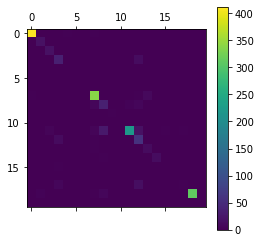

---------------------------------------------------------------



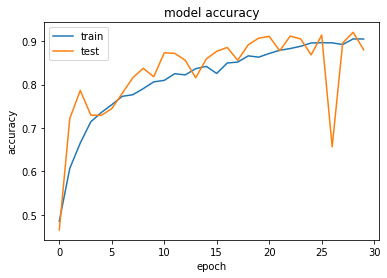

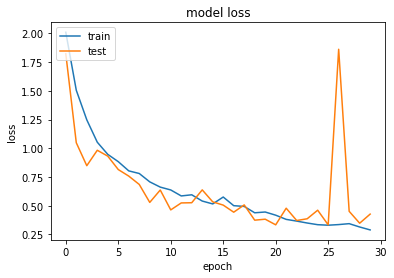

In [ ]:
# Evaluation of the model


# Accuracy on test set
loss, acc = model.evaluate(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)
print("---------------------------------------------------------------\n")


# Precision, recall and F1-score
preds = model.predict(test_generator,verbose=1,steps=val_steps)
Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator
#print("---------------------------------------------------------------\n")

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))
print("---------------------------------------------------------------\n")


# Confusion Matrix
cm = confusion_matrix(Ytest, Ypred)
print(cm, end="\n\n")
print("---------------------------------------------------------------\n")

pl.matshow(cm)
#pl.title("Confusion matrix of the classifier")
pl.colorbar()
pl.show()
print("---------------------------------------------------------------\n")


# Plot results

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
